In [1]:
import pandas as pd 
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM,Embedding, Dropout,Flatten, Bidirectional
from keras.models import Model, Sequential
import statistics 
import os 
import collections
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [3]:
df = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True )
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df= df.drop(['article_link'],axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [5]:
df['len'] = df['headline'].apply(lambda x : len(x.split(" ")))
max_len = max(df['len']) #the length of the headline containing maximum number of words
median = statistics.median(df['len'])
count = collections.Counter(df['len'])
print('maximum number of words in a headline: {0} \n Median of the number of words in all headlines: {1} \n Varying lengths of the headlines and their frequencies : \n {2} \n total samples {3}'.format(max_len,median,count, df.shape[0]))

df.head()

maximum number of words in a headline: 151 
 Median of the number of words in all headlines: 10 
 Varying lengths of the headlines and their frequencies : 
 Counter({10: 3636, 9: 3423, 11: 3395, 8: 2939, 12: 2843, 7: 2402, 13: 2084, 6: 1759, 14: 1491, 5: 1165, 15: 969, 4: 591, 16: 581, 17: 384, 3: 305, 18: 228, 19: 142, 2: 118, 20: 62, 21: 46, 22: 24, 23: 12, 24: 5, 27: 3, 29: 2, 28: 2, 25: 1, 151: 1, 31: 1, 26: 1, 34: 1, 38: 1, 39: 1, 30: 1}) 
 total samples 28619


,is_sarcastic,headline,len
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


In [6]:
max_features = 8000
last_most_frequent = 23
embedding_size = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X,maxlen=last_most_frequent,padding='post',truncating='post')
Y = df['is_sarcastic']


In [7]:
embedding_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
def pretrained_vectors(word,*a):
    return word,np.asarray(a,dtype=np.float32)

embeddings = dict(pretrained_vectors(*word_and_vectors.split(" ")) for word_and_vectors in open(embedding_file) if len(word_and_vectors) >100  ) 


In [8]:
all_embeds = np.stack(list(embeddings.values()))
embed_size = all_embeds.shape[1]
word_and_index = tokenizer.word_index

def matrix(word_and_index,max_features,embed_size):
    embedding_matrix = np.random.normal(size=(max_features,embed_size))
    for word,i in word_and_index.items():
        if i <= max_features:
            embedding_vector = embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
                
embedding_matrix= matrix(word_and_index=tokenizer.word_index,max_features= max_features, embed_size= embed_size)


In [9]:
def Model_LSTM(max_features, embedding_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(max_features,embedding_size,weights = [embedding_matrix], input_length=23, trainable = False))
    model.add(Bidirectional(LSTM(256, return_sequences = True,unit_forget_bias= True)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu' ))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


In [10]:
model = Model_LSTM(max_features,embed_size,embedding_matrix)
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1)
history = model.fit(X,Y,batch_size=64,epochs=25,verbose=1,validation_split=0.2,callbacks=[es])

Train on 22895 samples, validate on 5724 samples
Epoch 1/25
22895/22895 [==============================] - 19s 846us/step - loss: 0.5540 - accuracy: 0.7152 - val_loss: 0.4346 - val_accuracy: 0.7982
Epoch 2/25
22895/22895 [==============================] - 17s 754us/step - loss: 0.4088 - accuracy: 0.8149 - val_loss: 0.3655 - val_accuracy: 0.8401
Epoch 3/25
22895/22895 [==============================] - 18s 805us/step - loss: 0.3426 - accuracy: 0.8504 - val_loss: 0.3286 - val_accuracy: 0.8510
Epoch 4/25
22895/22895 [==============================] - 18s 767us/step - loss: 0.2955 - accuracy: 0.8716 - val_loss: 0.3351 - val_accuracy: 0.8550
Epoch 00004: early stopping


In [11]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

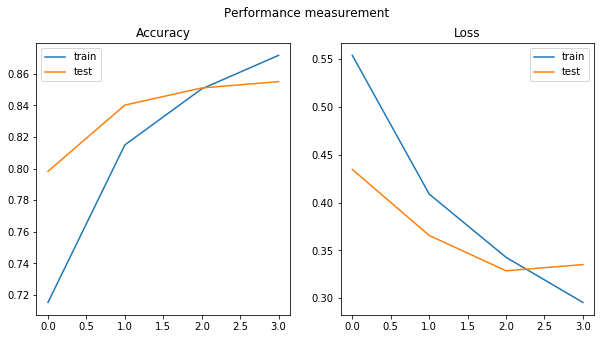

In [12]:
def plot(history):
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,5))
    fig.suptitle('Performance measurement')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title("Accuracy")
    ax1.legend(['train','test'])
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Loss')
    ax2.legend(['train','test'])
    plt.show()
    
model_plot = plot(history)